In [ ]:
!pip install -q scanpy[louvain]
!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

In [ ]:
drive.mount("/content/drive")
DATA = Path("/content/drive/My Drive/ecbm_4060")

sc.settings.set_figure_params(dpi=40)
sc.set_figure_params(scanpy=True, fontsize=24)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
melanoma_adata = sc.read_h5ad(DATA / "GSE72056.h5ad")
nsclc_adata = sc.read_h5ad(DATA / "GSE99254.h5ad")

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
sc.pp.filter_genes(melanoma_adata, min_cells=melanoma_adata.n_obs * 0.05)
sc.pp.filter_genes(nsclc_adata, min_cells=nsclc_adata.n_obs * 0.05)

In [ ]:
sc.pp.log1p(melanoma_adata)

In [ ]:
# The base is 2 in order help the threshold downstream.
sc.pp.log1p(nsclc_adata, base=2)

# Preprocessing to isolate CD8+ Cytotoxic T cells

In [ ]:
mel_t_adata = melanoma_adata[melanoma_adata.obs.non_malignant_cell_type == 1.0]

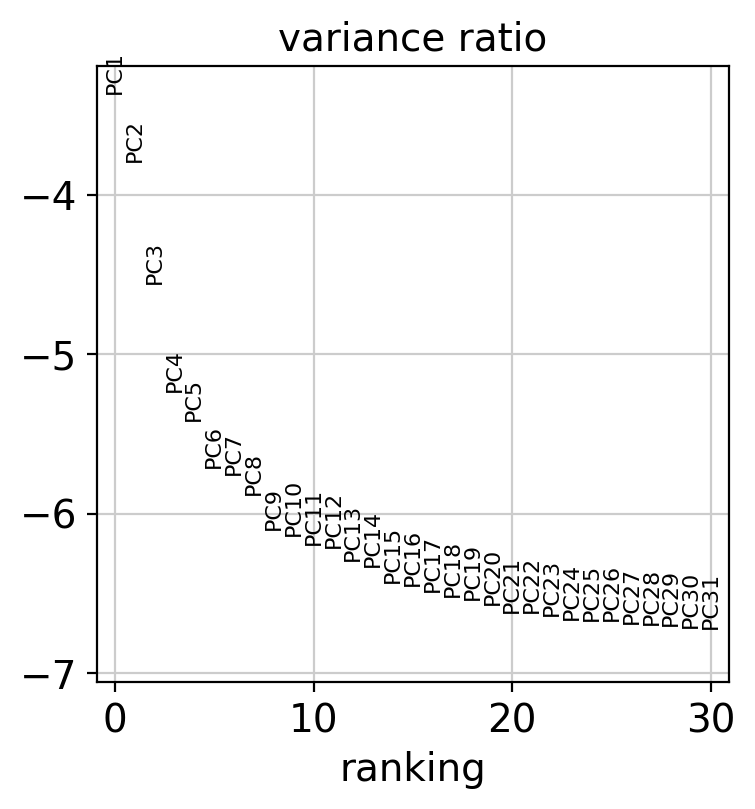

In [ ]:
sc.tl.pca(mel_t_adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(mel_t_adata, log=True)

### Based on the Kim et al. paper, we first Louvain cluster (default clustering method using Seurat), then select clusters with high expression of CD8A and CD8B, and low expressions of CD4.

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


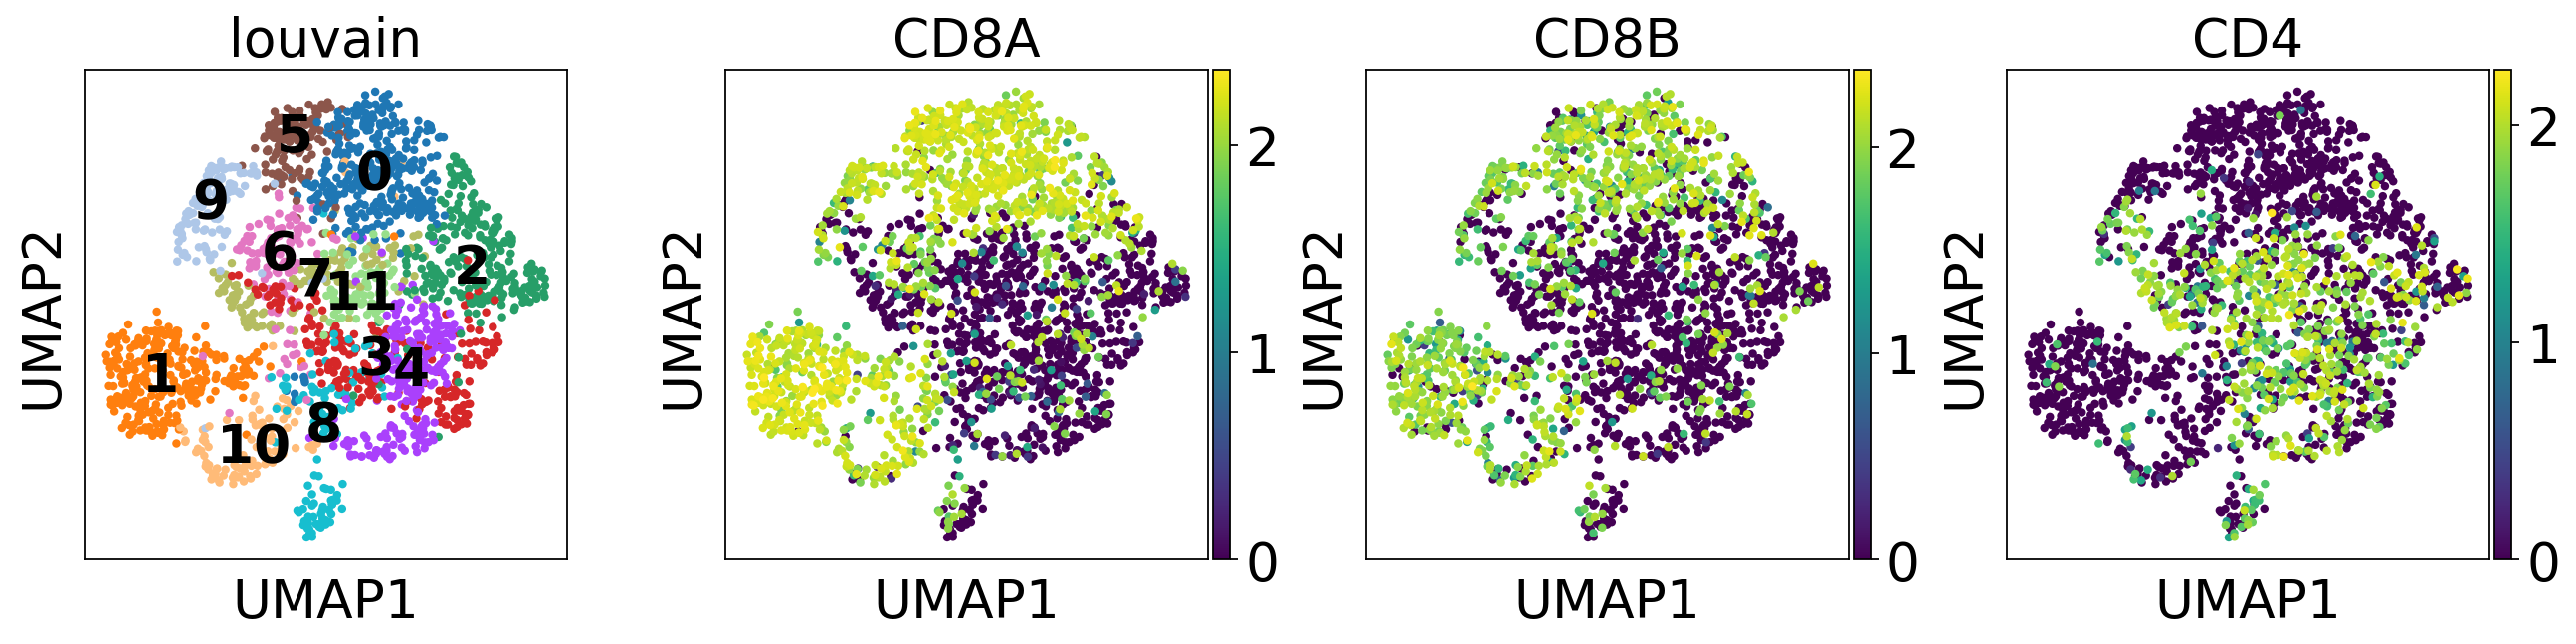

In [ ]:
sc.pp.neighbors(mel_t_adata, n_pcs=16, random_state=0)
sc.tl.umap(mel_t_adata, random_state=0)
sc.tl.louvain(mel_t_adata, random_state=0)
sc.pl.umap(mel_t_adata, color=["louvain", "CD8A", "CD8B", "CD4"], legend_loc="on data")

categories: 0, 1, 2, etc.
var_group_labels: CD4, CD8


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


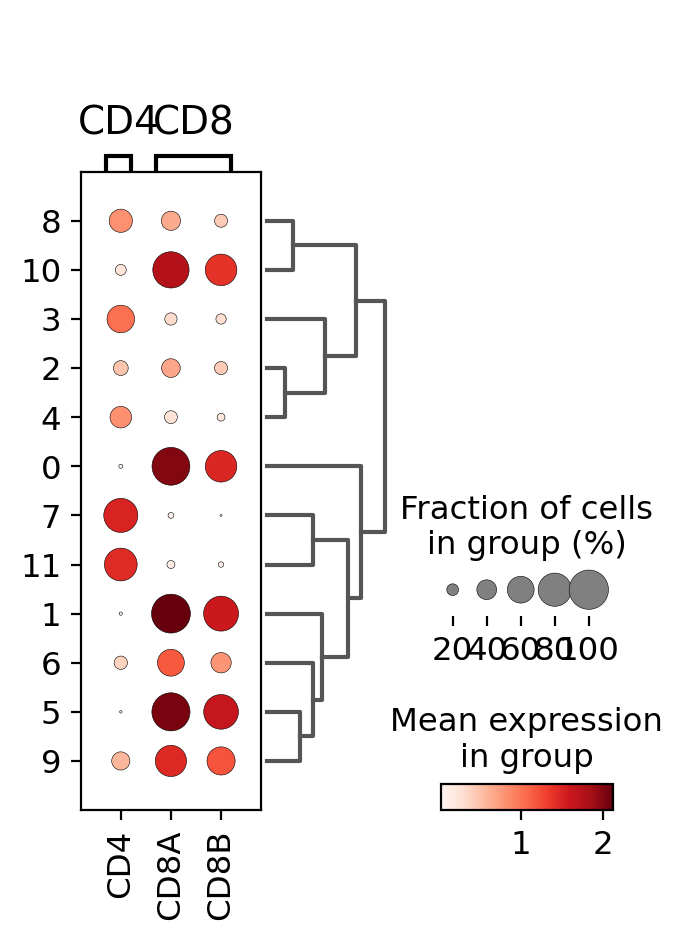

In [ ]:
sc.tl.dendrogram(mel_t_adata, groupby="louvain")
marker_genes = {
    'CD4': ['CD4'], # CD4 T cell
    'CD8': ['CD8A', 'CD8B'], # CD8 T cell
}

sc.pl.dotplot(mel_t_adata, marker_genes, groupby="louvain", dendrogram=True)

### This obtains 1066 cells compared to the 1072 cells obtained in Kim and Park et al.

In [ ]:
mel_cd8_adata = mel_t_adata[mel_t_adata.obs["louvain"].isin(["0", "1", "5", "6", "9", "10"])]
mel_cd8_adata

View of AnnData object with n_obs × n_vars = 1066 × 13368
    obs: 'cell', 'tumor', 'malignant', 'non_malignant_cell_type', 'louvain'
    var: 'gene', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'dendrogram_louvain'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### For the NSCLC dataset, subset by cell name, which contains what type the cell belongs to.

In [ ]:
nsclc_cd8_adata = nsclc_adata[nsclc_adata.obs["cell"].str.contains("TTC")]
nsclc_cd8_adata

View of AnnData object with n_obs × n_vars = 2123 × 12394
    obs: 'cell'
    var: 'gene', 'n_cells'
    uns: 'log1p'

# Differential gene expression analysis

In [ ]:
mel_cd8_pdcd1_median = np.median(mel_cd8_adata[:, "PDCD1"].X)
nsclc_cd8_pdcd1_median = np.median(nsclc_cd8_adata[:, "PDCD1"].X)

In [ ]:
print(mel_cd8_pdcd1_median)
print(nsclc_cd8_pdcd1_median)

1.7632222
0.697991


In [ ]:
mel_cd8_adata.obs["PDCD1_high"] = np.where(
    (mel_cd8_adata[:, "PDCD1"].X >= mel_cd8_pdcd1_median).ravel(),
    "high",
    "low"
)
nsclc_cd8_adata.obs["PDCD1_high"] = np.where(
    (nsclc_cd8_adata[:, "PDCD1"].X >= nsclc_cd8_pdcd1_median).ravel(),
    "high",
    "low"
)

<ipython-input-16-ccda4dc58a5e>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mel_cd8_adata.obs["PDCD1_high"] = np.where(
<ipython-input-16-ccda4dc58a5e>:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  nsclc_cd8_adata.obs["PDCD1_high"] = np.where(


In [ ]:
sc.tl.rank_genes_groups(mel_cd8_adata, groupby="PDCD1_high", method="wilcoxon", use_raw=False)
sc.tl.rank_genes_groups(nsclc_cd8_adata, groupby="PDCD1_high", method="wilcoxon", use_raw=False)

In [ ]:
mel_deg_names = [x for (_, x) in mel_cd8_adata.uns["rank_genes_groups"]["names"]]
mel_deg_p = [x for (_, x) in mel_cd8_adata.uns["rank_genes_groups"]["pvals_adj"]]
mel_deg_logfold = [x for (_, x) in mel_cd8_adata.uns["rank_genes_groups"]["logfoldchanges"]]

In [ ]:
mel_degs = pd.DataFrame(data={
    "names": mel_deg_names,
    "p_val": mel_deg_p,
    "logfold": mel_deg_logfold,
})
mel_degs = mel_degs[mel_degs.p_val < 0.05]

In [ ]:
mel_degs.shape

(75, 3)

In [ ]:
mel_pdcd1_low_mean = []
mel_pdcd1_high_mean = []
for name in mel_degs["names"]:
  mel_pdcd1_low_mean.append(
      mel_cd8_adata[mel_cd8_adata.obs["PDCD1_high"] == "low", name].X.ravel().mean()
  )
  mel_pdcd1_high_mean.append(
      mel_cd8_adata[mel_cd8_adata.obs["PDCD1_high"] == "high", name].X.ravel().mean()
  )

In [ ]:
mel_degs["pdcd1_low_mean"] = mel_pdcd1_low_mean
mel_degs["pdcd1_high_mean"] = mel_pdcd1_high_mean
mel_degs.head()

,names,p_val,logfold,pdcd1_low_mean,pdcd1_high_mean
0,ANXA1,0.000812,1.256403,0.6443807,0.32116994
1,RPL3,0.003947,0.067705,2.1942782,2.152689
2,RPL18A,0.005192,0.049269,2.1717904,2.1415915
3,ZNF696,0.006469,0.444658,0.38651332,0.29764855
4,RPS14,0.008788,0.058507,2.1888323,2.1529047


In [ ]:
# The DEG analysis performed in Kim and Park et al. seems to use non-log1p transformed data.
# Since I'm using log1p data, The threshold becomes 0.69 instead of 1.
mel_degs = mel_degs[(mel_degs.pdcd1_low_mean > 0.6931472) | (mel_degs.pdcd1_high_mean > 0.6931472)]
mel_degs.head()

,names,p_val,logfold,pdcd1_low_mean,pdcd1_high_mean
1,RPL3,0.003947,0.067705,2.1942782,2.152689
2,RPL18A,0.005192,0.049269,2.1717904,2.1415915
4,RPS14,0.008788,0.058507,2.1888323,2.1529047
5,RPS18,0.010209,0.045577,2.1935587,2.1655402
6,RPS3,0.010276,0.046748,2.1033638,2.0749717


In [ ]:
nsclc_deg_names = [x for (_, x) in nsclc_cd8_adata.uns["rank_genes_groups"]["names"]]
nsclc_deg_p = [x for (_, x) in nsclc_cd8_adata.uns["rank_genes_groups"]["pvals_adj"]]
nsclc_deg_logfold = [x for (_, x) in nsclc_cd8_adata.uns["rank_genes_groups"]["logfoldchanges"]]

In [ ]:
nsclc_degs = pd.DataFrame(data={
    "names": nsclc_deg_names,
    "p_val": nsclc_deg_p,
    "logfold": nsclc_deg_logfold,
})
nsclc_degs = nsclc_degs[nsclc_degs.p_val < 0.001]

In [ ]:
nsclc_pdcd1_low_mean = []
nsclc_pdcd1_high_mean = []
for name in nsclc_degs["names"]:
  nsclc_pdcd1_low_mean.append(
      nsclc_cd8_adata[nsclc_cd8_adata.obs["PDCD1_high"] == "low", name].X.ravel().mean()
  )
  nsclc_pdcd1_high_mean.append(
      nsclc_cd8_adata[nsclc_cd8_adata.obs["PDCD1_high"] == "high", name].X.ravel().mean()
  )

In [ ]:
nsclc_degs["pdcd1_low_mean"] = nsclc_pdcd1_low_mean
nsclc_degs["pdcd1_high_mean"] = nsclc_pdcd1_high_mean
nsclc_degs.head()

,names,p_val,logfold,pdcd1_low_mean,pdcd1_high_mean
0,GNRH1,8.526555e-31,-0.016567,1.0236616,1.0321035
1,ALG10B,1.072448e-24,-0.086913,1.0418596,1.0872122
2,C22orf15,1.326977e-23,0.107427,1.0605901,1.0056667
3,IL7R,6.865260e-22,1.203433,1.5183156,0.85572624
4,SND1-IT1,8.019368e-22,-0.088538,1.0314691,1.0773717


In [ ]:
nsclc_cd8_adata[:, "PDCD1"].X.ravel().mean()

ArrayView(2.4450438, dtype=float32)

In [ ]:
nsclc_degs = nsclc_degs[(nsclc_degs.pdcd1_low_mean > 2) | (nsclc_degs.pdcd1_high_mean > 2)]
nsclc_degs.head()

,names,p_val,logfold,pdcd1_low_mean,pdcd1_high_mean
80,SCML4,1.869627e-07,0.563110,2.432614,1.9917636
81,GLUL,2.123210e-07,0.805718,2.6531591,2.0095396
149,ANXA1,2.718038e-05,0.424945,2.5117326,2.1709328
160,XCL2,4.368411e-05,0.587823,2.1880229,1.7512522
161,LYAR,4.457079e-05,0.586336,2.0531306,1.6313547


In [ ]:
mel_degs.sort_values(by="logfold", ascending=False, inplace=True)
mel_degs.shape

(65, 5)

In [ ]:
nsclc_degs.sort_values(by="logfold", ascending=False, inplace=True)
nsclc_degs.shape

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(196, 5)

In [ ]:
mel_degs

,names,p_val,logfold,pdcd1_low_mean,pdcd1_high_mean
11,AOAH,2.577494e-02,0.630382,0.77318317,0.561707
19,EMP3,3.746741e-02,0.576627,0.871215,0.6585093
9,VIM,1.822463e-02,0.379507,1.4385716,1.2444768
18,UBE2G2,3.706259e-02,0.346695,0.9276948,0.7894223
12,GSG1,2.589424e-02,0.292574,0.9983978,0.87518907
17,RPL13A,3.442020e-02,0.153802,1.8898598,1.800107
10,RPS29,2.114243e-02,0.102250,1.9863483,1.9255
13,RPL8,3.174480e-02,0.099164,2.0104592,1.9512076
15,PABPC1,3.290713e-02,0.088237,1.7069194,1.6571356
8,RPLP2,1.819400e-02,0.081276,2.1086707,2.0593457


In [ ]:
nsclc_degs

,names,p_val,logfold,pdcd1_low_mean,pdcd1_high_mean
81,GLUL,2.123210e-07,0.805718,2.6531591,2.0095396
160,XCL2,4.368411e-05,0.587823,2.1880229,1.7512522
161,LYAR,4.457079e-05,0.586336,2.0531306,1.6313547
80,SCML4,1.869627e-07,0.563110,2.432614,1.9917636
149,ANXA1,2.718038e-05,0.424945,2.5117326,2.1709328
203,CXCR4,1.262663e-04,0.316915,2.0033724,1.7722524
6105,TMEM43,7.356890e-04,-0.038227,2.0630069,2.0921772
6364,SERINC3,4.695108e-04,-0.050240,2.0209312,2.0589533
5965,CNPY3,9.138775e-04,-0.050977,1.9944854,2.0328376
8226,RASSF1,9.023432e-06,-0.062241,2.0157626,2.0628603


In [ ]:
mel_degs.to_csv(DATA / "melanoma_markers_scanpy.csv")
nsclc_degs.to_csv(DATA / "nsclc_markers_scanpy.csv")

# UMAP Plotting using the DEGs identified in Kim and Park et al.

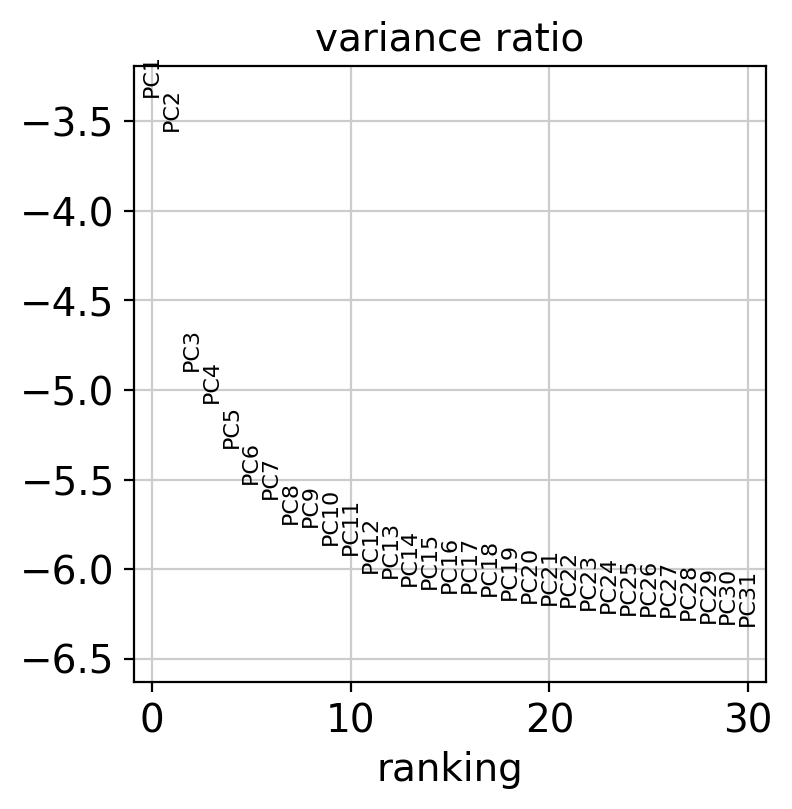

In [ ]:
sc.tl.pca(mel_cd8_adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(mel_cd8_adata, log=True)
sc.pp.neighbors(mel_cd8_adata, n_pcs=16, random_state=0)
sc.tl.umap(mel_cd8_adata, random_state=0)
sc.tl.louvain(mel_cd8_adata, random_state=0)

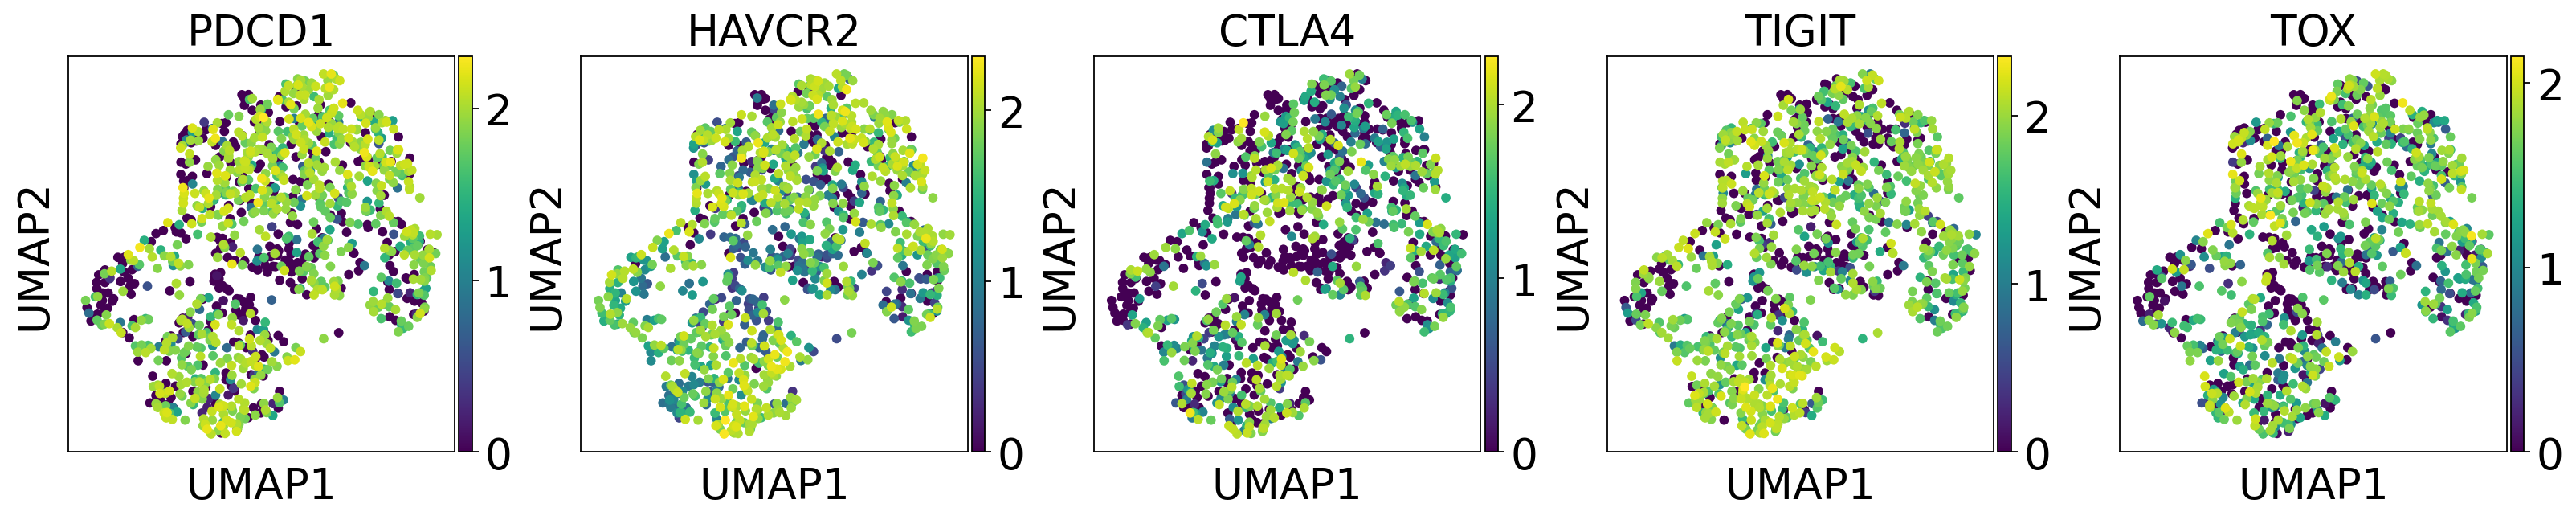

In [ ]:
sc.pl.umap(mel_cd8_adata, color=["PDCD1", "HAVCR2", "CTLA4", "TIGIT", "TOX"], ncols=5)

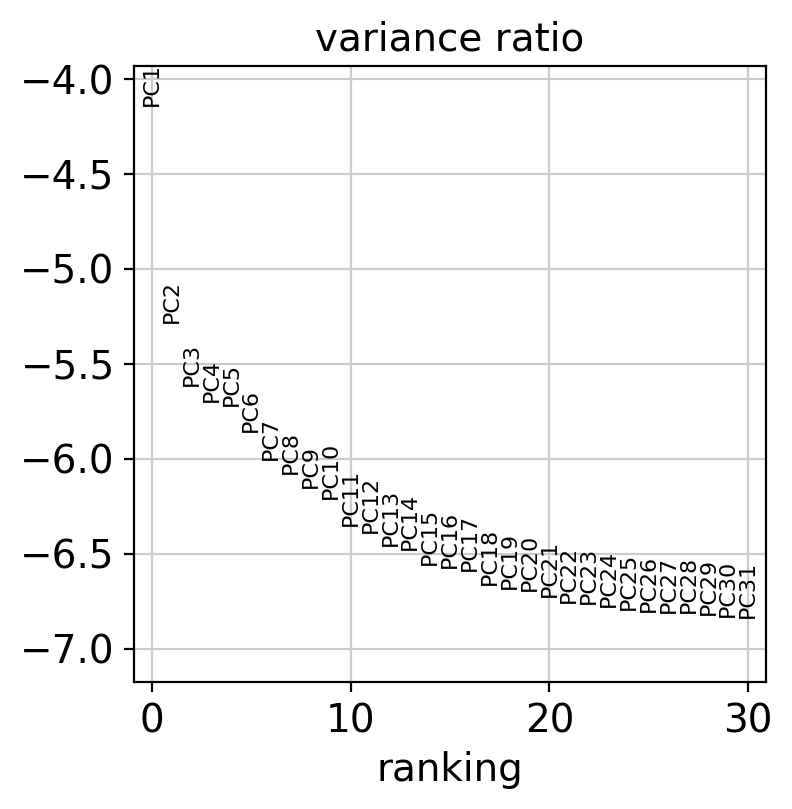

In [ ]:
sc.tl.pca(nsclc_cd8_adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(nsclc_cd8_adata, log=True)
sc.pp.neighbors(nsclc_cd8_adata, n_pcs=25, random_state=0)
sc.tl.umap(nsclc_cd8_adata, random_state=0)
sc.tl.louvain(nsclc_cd8_adata, random_state=0)

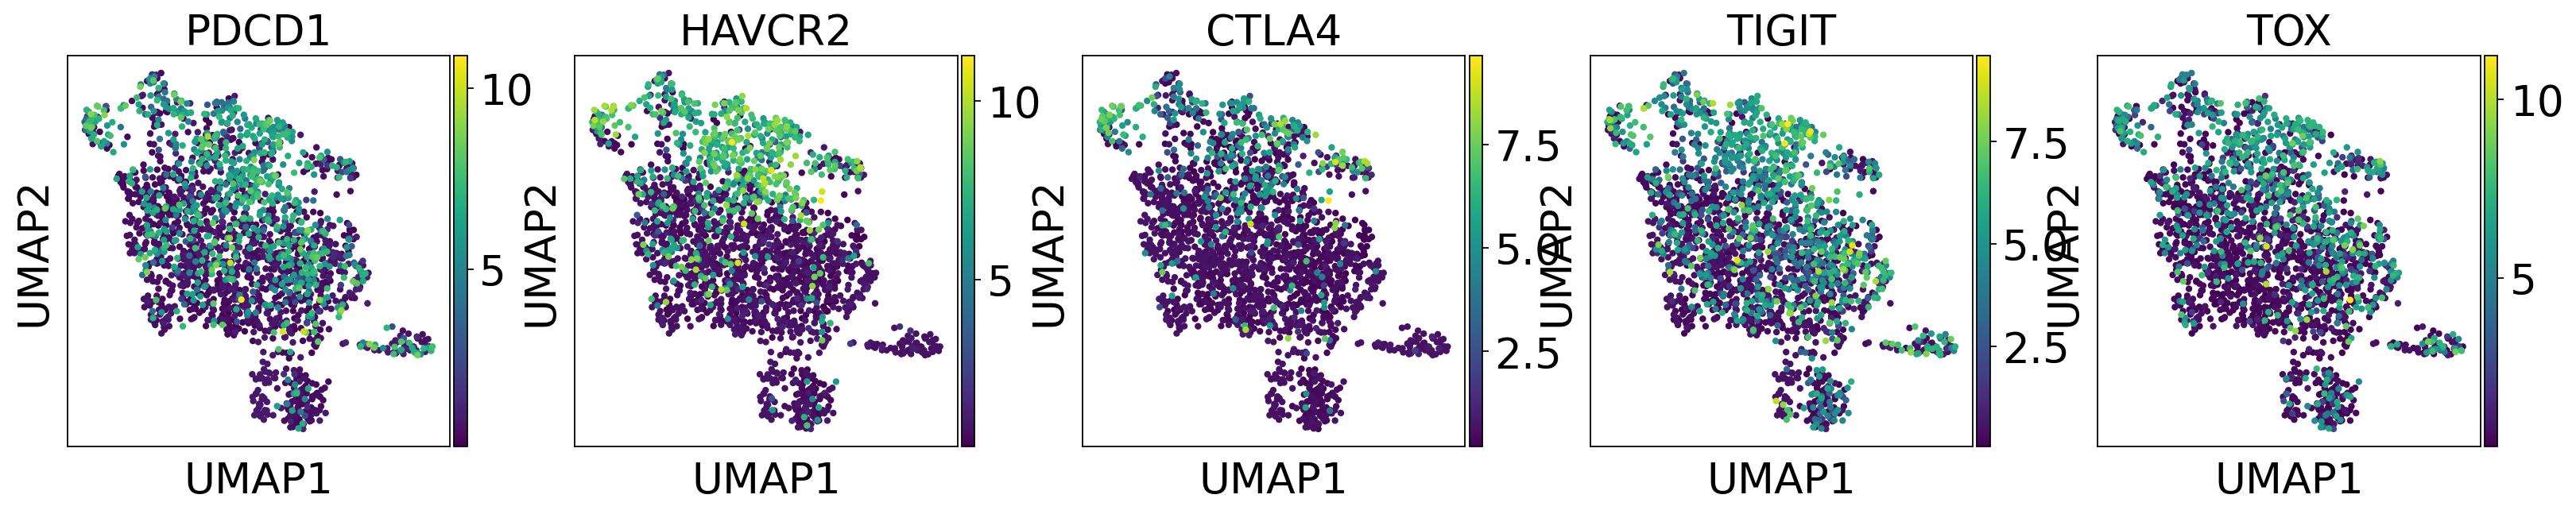

In [ ]:
sc.pl.umap(nsclc_cd8_adata, color=["PDCD1", "HAVCR2", "CTLA4", "TIGIT", "TOX"], ncols=5)

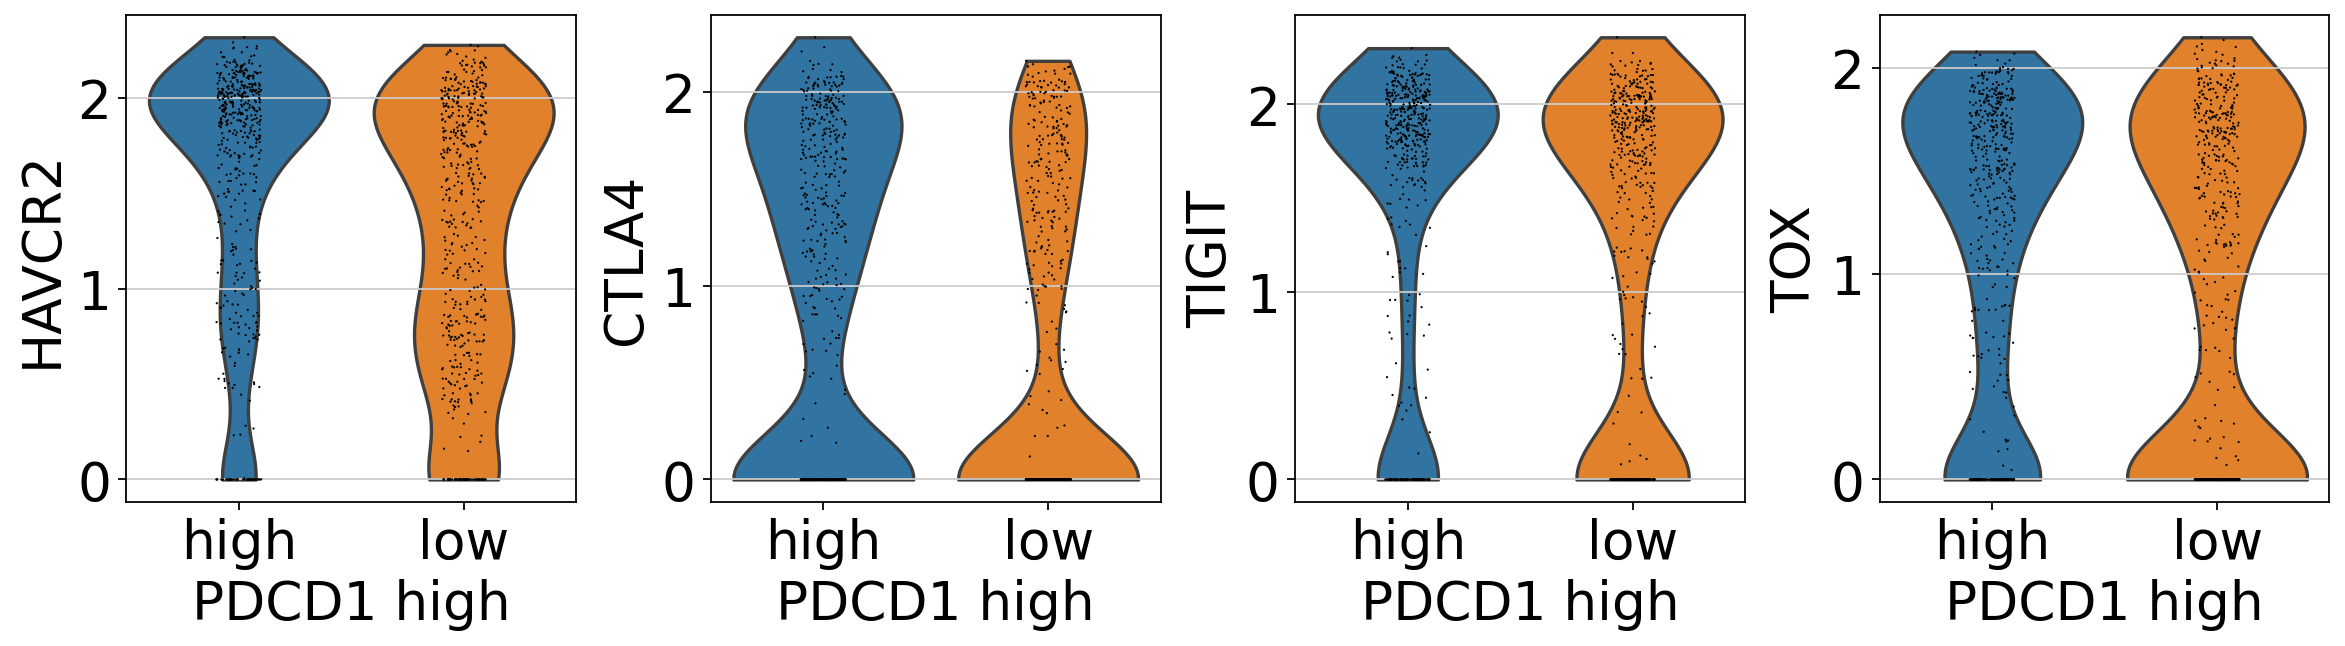

In [ ]:
sc.pl.violin(
    mel_cd8_adata,
    keys=["HAVCR2", "CTLA4", "TIGIT", "TOX"],
    groupby="PDCD1_high"
)

In [ ]:
mel_degs[mel_degs.names.isin(["HAVCR2", "CTLA4", "TIGIT", "TOX"])]["p_val"].values

array([2.82957041e-03, 2.07018477e-02, 3.42643572e-09, 5.53331481e-04])

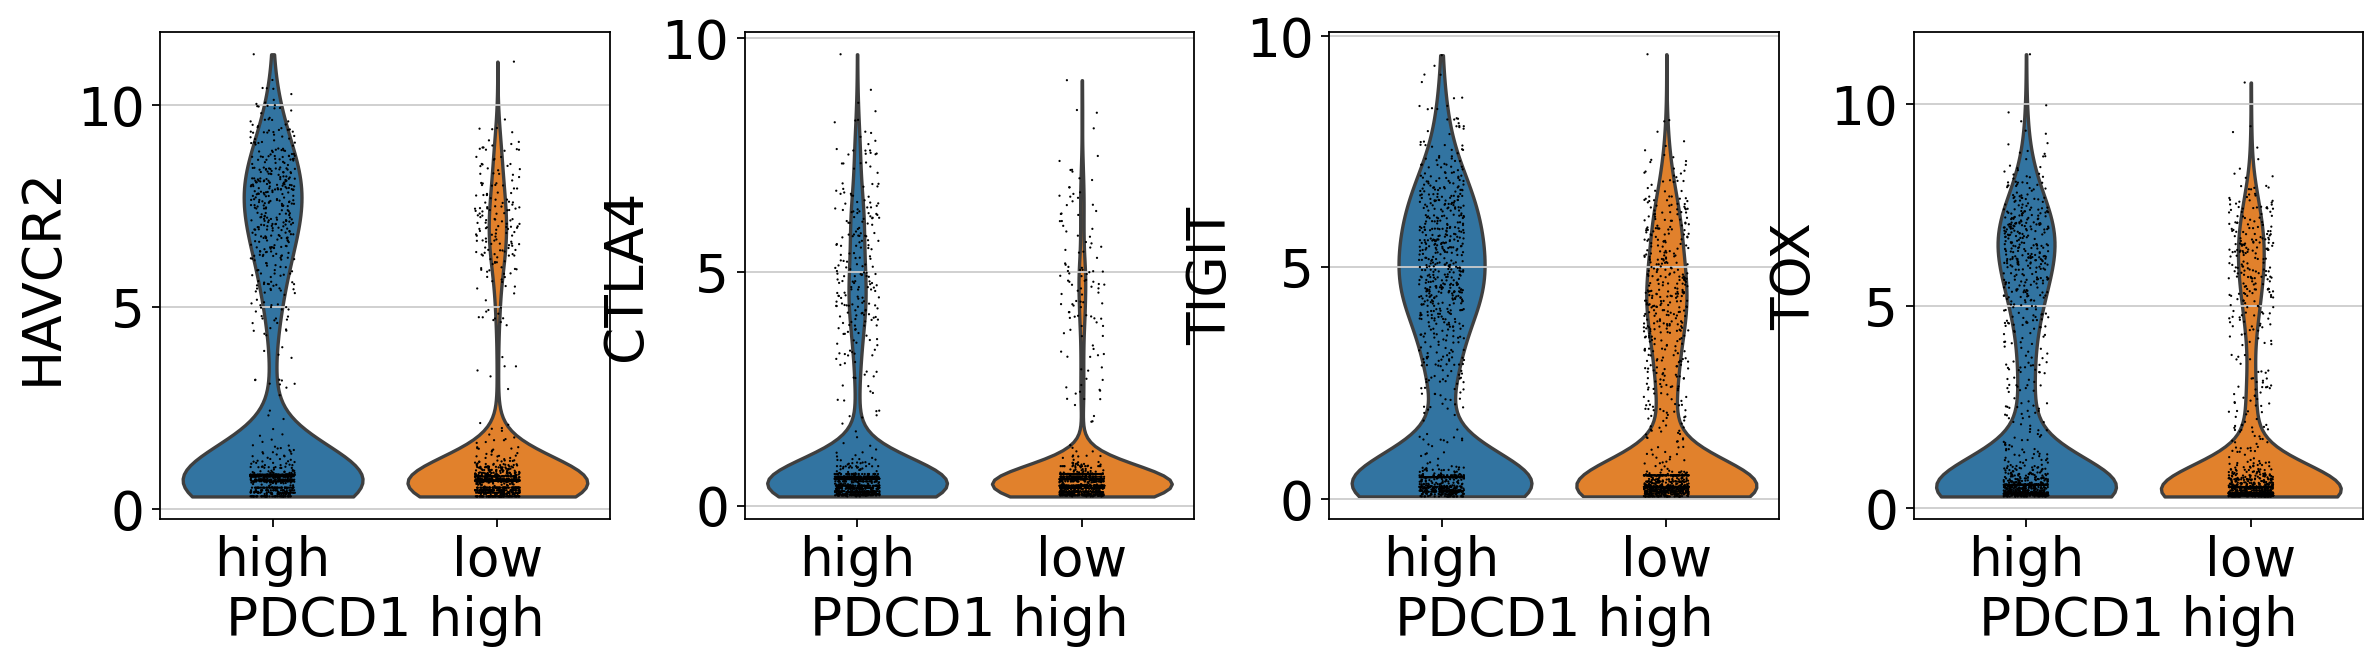

In [ ]:
sc.pl.violin(
    nsclc_cd8_adata,
    keys=["HAVCR2", "CTLA4", "TIGIT", "TOX"],
    groupby="PDCD1_high"
)

In [ ]:
nsclc_degs[nsclc_degs.names.isin(["HAVCR2", "CTLA4", "TIGIT", "TOX"])]["p_val"].values

array([3.41884374e-19, 2.09222439e-18, 1.08426585e-32])

In [ ]:
# it appears that CTLA4 didn't pass the expression mean filter
nsclc_degs[nsclc_degs.names.isin(["HAVCR2", "CTLA4", "TIGIT", "TOX"])]

,names,p_val,logfold,pdcd1_low_mean,pdcd1_high_mean
12287,TOX,3.418844e-19,-1.119954,1.8471932,2.7325916
12255,TIGIT,2.092224e-18,-1.258570,1.9159713,2.9328659
12391,HAVCR2,1.084266e-32,-1.859418,1.7428858,3.2504313


In [ ]:
[idx for idx, name in enumerate(nsclc_deg_names) if (name in ["HAVCR2", "CTLA4", "TIGIT", "TOX"])]

[9662, 12255, 12287, 12391]

In [ ]:
pd.Series(nsclc_deg_p)[[9662, 12255, 12287, 12391]]

9662     1.957404e-07
12255    2.092224e-18
12287    3.418844e-19
12391    1.084266e-32
dtype: float64